### Data preparation. Cleaning, feature engineering, transformation based on analysis from 02_data_analysis.ipynb

In [1]:
from pathlib import Path
import pandas as pd
from math import radians, sin, cos, sqrt, asin
import matplotlib.pyplot as plt

In [2]:
# times square coordinates
MANHATTAN_LAT = 40.7580
MANHATTAN_LON = -73.9855

In [3]:
airbnb_path = Path("../data/raw/AB_NYC_2019.csv")
airbnb_df = pd.read_csv(airbnb_path)

mta_stations_path = Path("../data/external/MTA_Subway_Stations.csv")
mta_stations_df = pd.read_csv(mta_stations_path)

airbnb_df.shape, mta_stations_df.shape

((48895, 16), (496, 19))

In [4]:
numeric_cols = [
    "price", "minimum_nights", "number_of_reviews",
    "reviews_per_month", "calculated_host_listings_count",
    "availability_365", "latitude", "longitude"
]

airbnb_df[numeric_cols] = airbnb_df[numeric_cols].apply(pd.to_numeric, errors="coerce")
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
airbnb_df["last_review"] = pd.to_datetime(airbnb_df["last_review"], errors="coerce")
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  object        
 5   neighbourhood                   48895 non-null  object        
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  object        
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [6]:
categorical_cols = ["neighbourhood_group", "neighbourhood", "room_type"]
airbnb_df[categorical_cols] = airbnb_df[categorical_cols].astype("category")
airbnb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              48895 non-null  int64         
 1   name                            48879 non-null  object        
 2   host_id                         48895 non-null  int64         
 3   host_name                       48874 non-null  object        
 4   neighbourhood_group             48895 non-null  category      
 5   neighbourhood                   48895 non-null  category      
 6   latitude                        48895 non-null  float64       
 7   longitude                       48895 non-null  float64       
 8   room_type                       48895 non-null  category      
 9   price                           48895 non-null  int64         
 10  minimum_nights                  48895 non-null  int64         
 11  nu

In [7]:
# drop rows with missing prices or if price less than or equal to zero
airbnb_df = airbnb_df.dropna(subset=["price"])
airbnb_df = airbnb_df[airbnb_df["price"] > 0]

airbnb_df.shape

(48884, 16)

In [8]:
# remove outliers by capping price at the 99th percentile
price_upper = airbnb_df["price"].quantile(0.99)
airbnb_df = airbnb_df[airbnb_df["price"] <= price_upper]

airbnb_df.shape

(48410, 16)

In [9]:
# the mta stations dataset can be reduced to only the relevant columns
mta_stations_df = mta_stations_df[
    ["GTFS Stop ID", "Stop Name", "Borough", "GTFS Latitude", "GTFS Longitude"]
].copy()

mta_stations_df = mta_stations_df.rename(columns={
    "GTFS Stop ID": "stop_id",
    "Stop Name": "stop_name",
    "Borough": "borough",
    "GTFS Latitude": "latitude",
    "GTFS Longitude": "longitude"
})
mta_stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   stop_id    496 non-null    object 
 1   stop_name  496 non-null    object 
 2   borough    496 non-null    object 
 3   latitude   496 non-null    float64
 4   longitude  496 non-null    float64
dtypes: float64(2), object(3)
memory usage: 19.5+ KB


### Feature engineering: distance to nearest subway station

For simplicity, I will use the `Haversine` formula to calculate distance between two coordinates (latitude and longitude) rather than `Djikstra` or `A*` for searching the shortest paths or calling external `Google Maps API`.

Articles:
- https://en.wikipedia.org/wiki/Haversine_formula
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
- https://nry.me/posts/2016-09-07/haversine-with-python/

In [10]:
def haversine(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    Returns distance in kilometers.
    """
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))

In [11]:
mta_stations_coords = mta_stations_df[["latitude", "longitude"]].values

def nearest_subway_distance(row: pd.Series) -> float:
    """Calculate distance to nearest subway station for a given Airbnb listing."""
    distances = [
        haversine(row["latitude"], row["longitude"], lat, lon)
        for lat, lon in mta_stations_coords
    ]
    return min(distances)

airbnb_df["distance_to_subway_km"] = airbnb_df.apply(nearest_subway_distance, axis=1)

In [12]:
airbnb_df[["latitude", "longitude", "distance_to_subway_km"]].head()

,latitude,longitude,distance_to_subway_km
0,40.64749,-73.97237,0.465364
1,40.75362,-73.98377,0.094923
2,40.80902,-73.94190,0.333712
3,40.68514,-73.95976,0.415913
4,40.79851,-73.94399,0.200187


In [13]:
# convert km to meters as the distances are small
airbnb_df["distance_to_subway_m"] = airbnb_df["distance_to_subway_km"] * 1000
airbnb_df = airbnb_df.drop(columns=["distance_to_subway_km"])

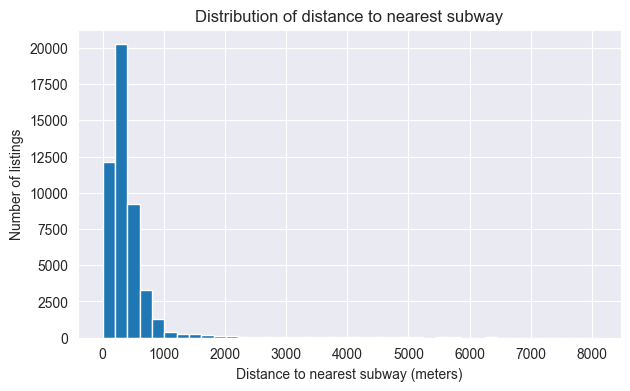

In [14]:
# histogram of distance to nearest subway

plt.figure(figsize=(7, 4))
airbnb_df["distance_to_subway_m"].hist(bins=40)
plt.xlabel("Distance to nearest subway (meters)")
plt.ylabel("Number of listings")
plt.title("Distribution of distance to nearest subway")
plt.show()

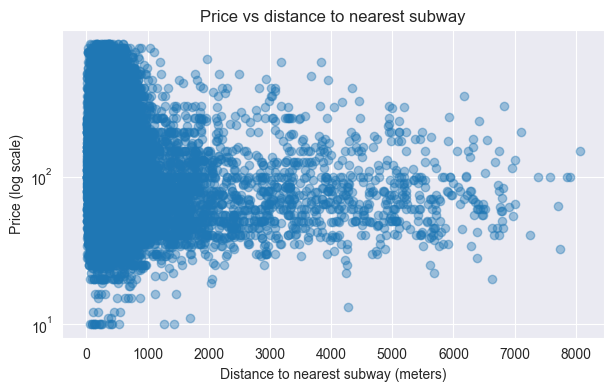

In [15]:
# scatter plot of price vs distance to nearest subway

plt.figure(figsize=(7, 4))
plt.scatter(
    airbnb_df["distance_to_subway_m"],
    airbnb_df["price"],
    alpha=0.4
)
plt.yscale("log")
plt.xlabel("Distance to nearest subway (meters)")
plt.ylabel("Price (log scale)")
plt.title("Price vs distance to nearest subway")
plt.show()

### Feature engineering: distance to Manhattan (Times Square)

In [16]:
airbnb_df["distance_to_manhattan_km"] = airbnb_df.apply(
    lambda row: haversine(
        row["latitude"],
        row["longitude"],
        MANHATTAN_LAT,
        MANHATTAN_LON
    ),
    axis=1
)

In [17]:
airbnb_df["distance_to_manhattan_km"].head(10)

0    12.337898
1     0.508366
2     6.757240
3     8.387034
4     5.701496
5     1.449704
6     8.290747
7     0.767636
8     5.105387
9     4.971807
Name: distance_to_manhattan_km, dtype: float64

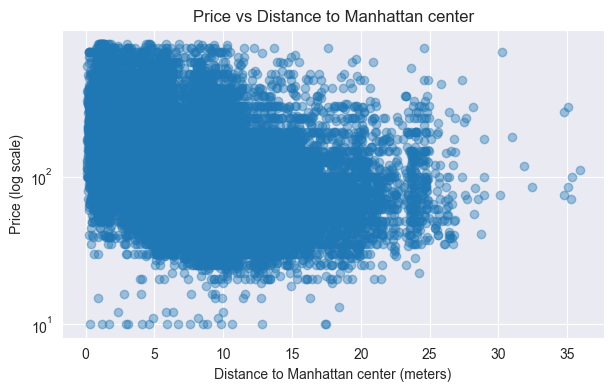

In [18]:
# histogram of distance to times square

plt.figure(figsize=(7, 4))
plt.scatter(
    airbnb_df["distance_to_manhattan_km"],
    airbnb_df["price"],
    alpha=0.4
)
plt.yscale("log")
plt.xlabel("Distance to Manhattan center (meters)")
plt.ylabel("Price (log scale)")
plt.title("Price vs Distance to Manhattan center")
plt.show()

In [19]:
# check missing values in airbnb_df

missing = airbnb_df.isna().sum().reset_index().rename(columns={"index": "feature", 0: "missing_count"})
missing.sort_values("missing_count", ascending=False)

,feature,missing_count
13,reviews_per_month,9827
12,last_review,9827
3,host_name,21
1,name,16
0,id,0
10,minimum_nights,0
16,distance_to_subway_m,0
15,availability_365,0
14,calculated_host_listings_count,0
11,number_of_reviews,0


In [20]:
airbnb_df["reviews_per_month"] = airbnb_df["reviews_per_month"].fillna(0)
airbnb_df = airbnb_df.drop(columns=["last_review"])

In [21]:
# transform availability_365 into a categorical feature

airbnb_df["availability_level"] = pd.cut(
    airbnb_df["availability_365"],
    bins=[-1, 60, 180, 365],
    labels=["low", "medium", "high"]
)
airbnb_df["availability_level"] = airbnb_df["availability_level"].astype("category")

In [22]:
# transform review_activity into a categorical feature
airbnb_df["review_activity"] = pd.cut(
    airbnb_df["reviews_per_month"],
    bins=[-0.1, 0, 2, airbnb_df["reviews_per_month"].max()],
    labels=["none", "low", "high"]
)

airbnb_df["review_activity"] = airbnb_df["review_activity"].astype("category")

In [23]:
# summary of feature types and missing values

feature_summary = pd.DataFrame({
    "feature": airbnb_df.columns,
    "dtype": airbnb_df.dtypes.astype(str),
    "missing_values": airbnb_df.isna().sum().values
})

feature_summary

,feature,dtype,missing_values
id,id,int64,0
name,name,object,16
host_id,host_id,int64,0
host_name,host_name,object,21
neighbourhood_group,neighbourhood_group,category,0
neighbourhood,neighbourhood,category,0
latitude,latitude,float64,0
longitude,longitude,float64,0
room_type,room_type,category,0
price,price,int64,0


In [24]:
airbnb_cleaned_path = Path("../data/processed/airbnb_nyc_cleaned.csv")
airbnb_df.to_csv(airbnb_cleaned_path, index=False)